# Monte Carlo simulations for Guaranteed Minimum Withdrawal Benefits for both discrete and continuous withdrawals

A guaranteed minimum withdrawal benefit (GMWB) is a type of rider or contract attached to some annuity insurance policies. It guarantees the policyholder a steady stream of annual withdrawals via the return of all premiums paid into the contract, regardless of an investment's performance, through a series of annual withdrawals. Usually, these types of riders ar designed to protesct policyholders during market downturns.

The Geometric Brownian Motion can be used to model the investment account balance, $W_t$, under the risk-neutral measure and it can be expressed as:
\begin{align}
dW(t) = [(r - \alpha) W(t) - G]dt + \sigma W(t) dB(t)
\end{align}.

where $r$ is the risk free interest rate,
$G$ is the continuous withdrawal rate, $\alpha$ is the continuous insurance charge,
$\sigma $ is the volatility of the Investment Account and $B(t)$ is the brownian motion under R-N measure.

The GMWB product $V(t,W)$ can be expressed as:
\begin{align}
V(t,W(t)) = E_t[(\int_{t}^{T} Ge^{-r(x-t)} \, dx) + e^{-r(T-t)} W^{+}(T)] 
\end{align}.

Since this product is to be sold to investors and the all amount recieved is invested into the investment account $W_0$, $V(0,W_0) = W_0$. Hence, assuming we fix $G$ and $r$, we will determine the insurance charge $\alpha$ s.t $V(0,W_0) = W_0$ is true. This can be done using monte carlo method as well as using a root finding such as Brent's method. 

In [5]:
import numpy as np
import pandas as pd
import random
from scipy import stats, optimize
import matplotlib.pyplot as plt
import math

## GMWB with continuous withdrawal

### Plain Monte Carlo Implementation

In [31]:
def MC_GMWB(w0,g,r,vol,T,alpha,n,m):
    dt = T/m
    sum = 0; hsquare = 0  
    for i in range(n):
        wt = w0
        z = np.random.normal(0,1,m)
        for j in range(m):
            #Euler scheme
            wt += ((r-alpha)*wt - g) * dt + vol* wt* math.sqrt(dt) * z[j]
            
        h = max(wt,0)
        sum += h
        hsquare += h**2

    
    v0: float = g*(1-math.exp(-r*T))/r + math.exp(-r*T) * sum / n
    SE = math.sqrt((hsquare/n - (sum/n) **2) / n)
    return round(v0,4), round(SE,4)

In [77]:
w0 = 100; r = 0.05;
g = 100; vol = 0.05;
alpha = 1 #Insurance charge rate
n = 10000; m = 100; T = 1

MC_GMWB(w0,g,r,vol,T,alpha,n,m)

(97.5412, 0.0)

### Root Searcher (Brent's Method)

In [78]:
w0 = 100; r = 0.05;
g = 100; vol = 0.05;
n = 10000; m = 100; T = 1

a = 1; b = 0.00001

f = lambda alpha: (MC_GMWB(w0,g,r,vol,T,alpha,n,m)[0] - w0)
alpha = optimize.brentq(f, a, b)
print("Insurance Charge = ", alpha)

Insurance Charge =  0.007525067340635382


We will now rerun the monte carlo using the fair value $\alpha$ to see the average as well as the standard error. We will also increase the no. of simulations

In [80]:
w0 = 100; r = 0.05;
g = 100; vol = 0.05;
n = 10000; m = 1000; T = 1

avg,se = MC_GMWB(w0,g,r,vol,T,alpha,n,m)
print(f'The price of GMWB is {avg} and the Standard Error is {se}')

The price of GMWB is 100.0037 and the Standard Error is 0.0249


### Monte Carlo Implementation using Antithetic Sampling

We will now try to lower our estimate error by using Antithetic Sampling. Antithetic Sampling is a variance reduction technique that helps to improve the monte carlo estimate by using 2 samples that are negatively correlated. In this example, we will use $Z_1$ and $Z_2 = -Z_1$, where $Z_1$ are generated from standard normal distribution, $Z$ ~ $N(0,1)$.

In [20]:
def MC_GMWB_Anti(w0,g,r,vol,T,alpha,n,m):
    dt = T/m
    sum = 0; hsquare = 0  
    for i in range(n):
        wt1,wt2 = w0,w0
        z = np.random.normal(0,1,m)
        for j in range(m):
            #Euler scheme
            wt1 += ((r-alpha)*wt1 - g) * dt + vol* wt1* math.sqrt(dt) * z[j]
            wt2 += ((r-alpha)*wt2 - g) * dt + vol* wt2* math.sqrt(dt) * -z[j]
        h = max(wt1,0) + max(wt2,0)
        sum += h/2
        hsquare += (h/2)**2

    
    v0: float = g*(1-math.exp(-r*T))/r + math.exp(-r*T) * sum / n
    SE = math.sqrt((hsquare/n - (sum/n) **2) / n)
    return round(v0,4), round(SE,4)

In [21]:
w0 = 100; r = 0.05;
g = 100; vol = 0.05;
n = 10000; m = 1000; T = 1
alpha = 0.007525067340635382
avg,se = MC_GMWB_Anti(w0,g,r,vol,T,alpha,n,m)
print(f'The price of GMWB is {avg} and the Standard Error is {se}')

The price of GMWB is 99.9917 and the Standard Error is 0.0073


### Monte Carlo Implementation using Control Variate

By introducing a control variate that is positvely correlated with the investment account balance, $W_t$, we can reduce the error of our monte carlo estimate. The choice of the control variate is crucial since highly postive correlation is desired. The equation below shows the importance of high correlation: <br>
$Var(\hat{\mu}) = (1 - \beta^2)\sigma_x^2/n$, where $\beta$ is the correlation coefficient between X (Intial Variate) and Y (Control variate).

For this example, we can use the virtual final account balance as the control variate where there is no withdrawal, $W'_t$. We know that at t =T, $W_T$ and $W'_T$ will be postively correlated since they share the same brownian motion. <br>
$dW(t) = [(r - \alpha) W(t) - G]dt + \sigma W(t) dB(t) - (1)$ <br>
$dW'(t) = (r - \alpha) W'(t)dt + \sigma W'(t) dB(t) - (2)$<br>
$E_t(W'_T) = W'_t e^{(r-\alpha)(T-t)}$, the expected value of $W'_T$ will just be the forward value.



The GMWB product $V(t,W,W')$ can be expressed as:
\begin{align}
V(t,W(t)) = E_t[(\int_{t}^{T} Ge^{-r(x-t)} \, dx) + e^{-r(T-t)} ( W^{+}(T) - b(W'_T - \bar{W'_T}))] 
\end{align}.

In [28]:
def MC_GMWB_CV(w0,g,r,vol,T,alpha,n,m):
    dt = T/m
    sum = 0; hsquare = 0
    X_T = np.zeros(n); Y_T = np.zeros(n)
    for i in range(n):
        wt = w0; wt_prime = w0
        z = np.random.normal(0,1,m)
        for j in range(m):
            #Euler scheme
            wt_prime += (r-alpha)*wt_prime * dt + vol* wt_prime* math.sqrt(dt) * z[j]
            wt += ((r-alpha)*wt - g) * dt + vol* wt* math.sqrt(dt) * z[j]
        X_T[i] = max(wt,0)  
        Y_T[i] = wt_prime
        
    b_star = np.sum((X_T - np.mean(X_T)) * (Y_T - np.mean(Y_T))) / np.sum((Y_T - np.mean(Y_T))**2)
    #print(b_star)
    #print(np.mean(Y_T))
    #print(w0 * np.exp((r-alpha)*T))
    
    H = X_T - b_star * (Y_T - w0 * np.exp((r-alpha)*T))
    
    est = np.sum(H)/n
    v0: float = g*(1-math.exp(-r*T))/r + math.exp(-r*T) * est
    SE = np.sqrt((np.sum(H**2) - n*est**2) /n/(n-1))
    return round(v0,4), round(SE,4)

In [29]:
w0 = 100; r = 0.05;
g = 100; vol = 0.05;
n = 10000; m = 1000; T = 1
alpha = 0.007525067340635382

avg,se = MC_GMWB_CV(w0,g,r,vol,T,alpha,n,m)
print(f'The price of GMWB is {avg} and the Standard Error is {se}')

The price of GMWB is 100.011 and the Standard Error is 0.0137


### Comparing Plain MC vs Antithetic MC vs Control Variate MC

In [32]:
w0 = 100; r = 0.05;
g = 100; vol = 0.05;
n = 10000; m = 1000; T = 1;
alpha = 0.007525067340635382;
df = pd.DataFrame([MC_GMWB(w0,g,r,vol,T,alpha,n,m),MC_GMWB_Anti(w0,g,r,vol,T,alpha,n,m),MC_GMWB_CV(w0,g,r,vol,T,alpha,n,m)]
                  , columns = ['Price','SE'])

Text(0.5, 1.0, 'Price of options using different MC methods using 10,000 samples')

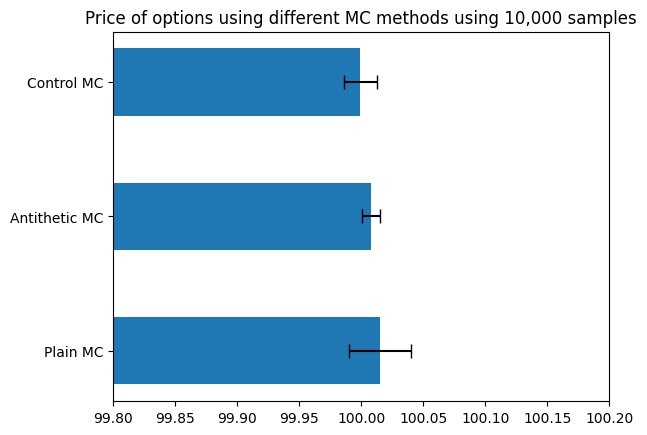

In [36]:
#plt.figure(figsize=(8,6))
plt.barh(y=range(len(df)), width=df['Price'], xerr=df['SE'],capsize = 5,height = 0.5)
plt.yticks(range(len(df)), ['Plain MC','Antithetic MC', 'Control MC'],fontsize = 10)
plt.xlim(99.8,100.2)
plt.title('Price of options using different MC methods using 10,000 samples')

Based on the horizontal bar plot above, we obeserve that variance reduction methods like Anthithetic sampling and Control variate reduced the standard error of the estimate as compared to plain monte carlo. Anithetic MC seems to have the lowest SE followed by Control MC and finally Plain MC.

One reason Anithetic MC having lower SE than Control MC is that the choice of Control Variate here might not be the most ideal. The virtual account balance $W'_t$ is definitely positively correlated to $W_t$ but the lack of withdawal $G$ affects the level of correlation between the 2 random variables.

## GWMB with discrete withdrawal

Instead of continuous withdrawals, we can also price the GWMB using discerete withdrawals.

The Geometric Brownian Motion can be used to model the investment account balance, $W_t$, under the risk-neutral measure and it can be expressed as:

\begin{align}
At\ t\neq t_i,\ dW(t) = (r - \alpha) W(t)dt + \sigma W(t) dB(t) \\
At\ t = t_i,\ W(t_i+) = (W(t_i-) - G_i)^{+}
\end{align}.

The GMWB product with discrete withdrawals $V(t,W)$ can be expressed as:
\begin{align}
V(t,W(t)) = E_t[e^{-r(T-t)} W^{+}(T)] + \sum_{i=1}^{I} G_i e^{-rt_i}
\end{align}.

where $t_i,i = 1,2,..,I$ are the discrete withdrawal times and $t_I = T$

Similar to the continuous case, we will find the fair value insurance charge $\alpha$ such that $V(0,W_0;\alpha) = W_0$

In [89]:
def MC_GMWB_Discrete(w0,g,r,vol,T,alpha,nPath,fixings):
    
    #fixings are the monitoring dates
    fixings = [0] + fixings
    dts = [fixings[i+1] - fixings[i] for i in range(len(fixings) - 1)]
    
    #print(dts)
    #print(fixings)
    #print(g)
    
    sum, hsquare = 0,0
    for i in range(nPath):
        x = math.log(w0)
        for j in range(len(dts)):
            z = np.random.normal(0,1)
            x += (r-alpha - vol**2/2) * dts[j] + vol * math.sqrt(dts[j]) * z 
            w = max(math.exp(x) - g[j],0)
            if w == 0:
                break
            else:
                x = math.log(w)
        
        if w == 0:
            h = 0
        else:
            h = math.exp(-r*T) * math.exp(x)
        
        sum += h
        hsquare += h**2

    t = 0
    for z in range(len(dts)):
        t += g[z] * math.exp(-r*fixings[z+1])
        
        
    pv = sum / nPath
    se = math.sqrt((hsquare/nPath - (pv)**2)/nPath)
    return t + pv,se

In [94]:
g = [10,10,10,10,10]
fixings = [1,2,3,4,5]

alpha = 0.001; #Insurance charge rate
w0 = 50; r = 0.05; vol = 0.2;
nPath = 10000; T = 1

In [95]:
MC_GMWB_Discrete(w0,g,r,vol,T,alpha,n,fixings)

(54.48312226168227, 0.17019759940352394)

In [96]:
a = 0.1; b = 0.001

f = lambda alpha: (MC_GMWB_Discrete(w0,g,r,vol,T,alpha,n,fixings)[0] - w0)
alpha = optimize.brentq(f, a, b)
print("Insurance Charge = ", alpha)

Insurance Charge =  0.036154407426559634


# Conclusion

In both the discrete and continuous withdrawal scenarios, we are able to use monte carlo and a root searcher to get the fair value of insurance charge of the GMWB product. However, in this example, we assumed volatility and interest rates to be constant. However, we can further extend this model by using stochastic interest rates and volatility.

If we further allow for dynamic withdrawals where $G$ is not fixed at present time, the problem becomes more complicated since we now need to find the optimal withdrawal strategy that maximises the value of the GMWB product. In such cases, using Monte-Carlo simulations becomes near impossible and a PDE approach is required.
